# Amazon Earnings Transcript Scraper (Q1–Q4 FY2024)

This notebook scrapes earnings call transcripts for Amazon (Q1–Q4 FY2024) from Fool.com, cleans the raw text to remove disclaimers and noise, and saves each cleaned transcript to a separate file.
## Amazon's fiscal year runs from January 1st to December 31st.
**Steps Covered:**
1. Scrape earnings call transcripts using Selenium
2. Clean the scraped text
3. Save a single cleaned `.txt` file for each quarter

In [2]:
#First, we import libraries needed 
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time  
import os
import re

# Libraries
import sys
import pandas as pd
from openai import OpenAI
import json
import io

# Step 1: Scrape Transcript from Fool.com

This function uses Selenium to open the transcript webpage, accept cookies, and extract all paragraph text from the main article body.


In [2]:
#Now, we run the scraping function
def scrape_clean_transcript(url):
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(url)
    time.sleep(5)

    # Accept cookie banner if present
    try:
        driver.find_element(By.XPATH,'/html/body/div[13]/div[2]/div/div/div[2]/div/div/button[2]').click()
        time.sleep(1)
    except:
        pass

    # Extract the article content
    try:
        article_body = driver.find_element(By.XPATH, "/html/body/div[9]/div[3]/div[2]/section[2]/div/div[2]/div[1]/div[1]")
        paragraphs = article_body.find_elements(By.XPATH, "//p")
        raw_text = "\n".join([p.text for p in paragraphs if p.text.strip()])
    except Exception as e:
        print(f"Error extracting transcript from {url}: {e}")
        raw_text = ""

    driver.quit()
    return raw_text


# Step 2: Clean the Transcript Text

This function removes empty lines and disclaimer/legal language. It also collapses multiple line breaks into a single one.


In [3]:
def clean_transcript(text):
    lines = text.strip().split("\n")

    # 1. Remove leading "header" lines if they look like heading metadata
    cleaned_lines = []
    for line in lines:
        if (
            any(kw in line.lower() for kw in ["image source", "amazon", "earnings call", "et"]) and
            len(cleaned_lines) < 5
        ):
            continue
        cleaned_lines.append(line.strip())

    text = "\n".join(cleaned_lines).strip()

    # 2. Truncate known footer section
    footer_start = text.find("More AMZN analysis")
    if footer_start != -1:
        text = text[:footer_start].strip()

    # 3. Clean up legal terms and short lines
    final_lines = []
    for line in text.split("\n"):
        if len(line.strip()) < 5:
            continue
        if any(term in line.lower() for term in ["forward-looking", "safe harbor", "disclaimer"]):
            continue
        final_lines.append(line.strip())

    cleaned_text = "\n".join(final_lines)
    return re.sub(r'\n+', '\n', cleaned_text)



# Step 3: Save Cleaned Transcript to File

This function saves the cleaned transcript to a `.txt` file inside the `clean_transcripts/` directory.


In [4]:
def save_transcript(text, filename):
    os.makedirs("clean_transcripts", exist_ok=True)
    path = os.path.join("clean_transcripts", filename)
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"Saved: {path}")

# Step 4: Process All Four Quarters (Q1–Q4 FY2025)

We define a dictionary of transcript URLs and filenames. The script loops through them, scrapes the data, cleans it, and saves the result.


In [5]:
transcripts = {
    "AMZN_q1_2024.txt": "https://www.fool.com/earnings/call-transcripts/2024/04/30/amazoncom-amzn-q1-2024-earnings-call-transcript/",
    "AMZN_q2_2024.txt": "https://www.fool.com/earnings/call-transcripts/2024/08/01/amazoncom-amzn-q2-2024-earnings-call-transcript/",
    "AMZN_q3_2024.txt": "https://www.fool.com/earnings/call-transcripts/2024/10/31/amazoncom-amzn-q3-2024-earnings-call-transcript/",
    "AMZN_q4_2024.txt": "https://www.fool.com/earnings/call-transcripts/2025/02/06/amazoncom-amzn-q4-2024-earnings-call-transcript/"
}

for filename, url in transcripts.items():
    print(f"\nProcessing {filename} ...")
    raw = scrape_clean_transcript(url)
    clean = clean_transcript(raw)
    save_transcript(clean, filename)



Processing AMZN_q1_2024.txt ...
Saved: clean_transcripts/AMZN_q1_2024.txt

Processing AMZN_q2_2024.txt ...
Saved: clean_transcripts/AMZN_q2_2024.txt

Processing AMZN_q3_2024.txt ...
Saved: clean_transcripts/AMZN_q3_2024.txt

Processing AMZN_q4_2024.txt ...
Saved: clean_transcripts/AMZN_q4_2024.txt


# Step 5: Preprocess the Cleaned Transcripts

In [6]:
import os
import re
import pandas as pd

# Define the input transcript files and associated quarters
transcript_files = {
    'Q1_2024': 'clean_transcripts/AMZN_q1_2024.txt',
    'Q2_2024': 'clean_transcripts/AMZN_q2_2024.txt',
    'Q3_2024': 'clean_transcripts/AMZN_q3_2024.txt',
    'Q4_2024': 'clean_transcripts/AMZN_q4_2024.txt',
}

records = []

# Improved regex pattern for speaker lines
speaker_pattern = re.compile(
    r'^(?P<speaker>([A-Z][a-zA-Z.,\'-]+\s){1,3}[A-Z][a-zA-Z.,\'-]+)\s--\s(?P<title>[A-Za-z][^:\n]+)$'
)

for quarter, path in transcript_files.items():
    with open(path, 'r', encoding='utf-8') as f:
        current_speaker = None
        current_title = None
        buffer = []

        for raw_line in f:
            line = raw_line.strip()

            # Remove notes like [Operator Instructions]
            line = re.sub(r'\[.*?\]', '', line).strip()
            if not line:
                continue

            match = speaker_pattern.match(line)
            if match:
                # Save previous speaker block
                if current_speaker and buffer:
                    content = ' '.join(buffer).strip()
                    if len(content) > 30:
                        records.append({
                            'quarter': quarter,
                            'speaker': current_speaker,
                            'title': current_title,
                            'content': content
                        })

                # Start new block
                current_speaker = match.group('speaker').strip()
                current_title = match.group('title').strip()
                buffer = []

            else:
                # If line is misparsed (e.g. a regular sentence starting with "And I..."), just append to buffer
                buffer.append(line)

        # Flush the last block
        if current_speaker and buffer:
            content = ' '.join(buffer).strip()
            if len(content) > 30:
                records.append({
                    'quarter': quarter,
                    'speaker': current_speaker,
                    'title': current_title,
                    'content': content
                })

# Save to DataFrame
df = pd.DataFrame(records)

# Optional: forward-fill missing speakers and titles (if you later add edge case handling)
df['speaker'].ffill(inplace=True)
df['title'].ffill(inplace=True)

# Save to CSV
output_path = 'clean_transcripts/AMAZON_all_quarters_speaker_blocks.csv'
df.to_csv(output_path, index=False)
print(f"Saved {len(df)} speaker blocks to {output_path}")


df['speaker'].ffill(inplace=True)
if 'title' in df.columns:
    df['title'].ffill(inplace=True)

# Save cleaned speaker blocks
output_path = 'clean_transcripts/AMAZON_all_quarters_speaker_blocks.csv'
df.to_csv(output_path, index=False)

print(f"Saved {len(df)} speaker blocks to {output_path}")


Saved 73 speaker blocks to clean_transcripts/AMAZON_all_quarters_speaker_blocks.csv
Saved 73 speaker blocks to clean_transcripts/AMAZON_all_quarters_speaker_blocks.csv


/var/folders/83/nqzb59wj61z0p5qbhhc8bq9m0000gn/T/ipykernel_32909/894408720.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['speaker'].ffill(inplace=True)
/var/folders/83/nqzb59wj61z0p5qbhhc8bq9m0000gn/T/ipykernel_32909/894408720.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [7]:
# Load the uploaded CSV file containing all quarters' speaker blocks
df_speaker_blocks = pd.read_csv("clean_transcripts/AMAZON_all_quarters_speaker_blocks.csv")

# Display the first few rows to confirm structure
df_speaker_blocks.head(8)

,quarter,speaker,title,content
0,Q1_2024,Dave Fildes,"Director, Investor Relations",They just revealed what they believe are the 1...
1,Q1_2024,Andy Jassy,Chief Executive Officer,"Thanks, Dave. Today, we're reporting $143.3 bi..."
2,Q1_2024,Brian Olsavsky,Chief Financial Officer,"Thanks, Andy. Starting with our top line finan..."
3,Q1_2024,Doug Anmuth,JPMorgan Chase and Company -- Analyst,Thanks so much for taking the question. Probab...
4,Q1_2024,Brian Olsavsky,Chief Financial Officer,"Hi. Doug, yeah, we have historically always me..."
5,Q1_2024,Andy Jassy,Chief Executive Officer,"Yeah, I just would add briefly, just to summar..."
6,Q1_2024,Ross Sandler,Barclays -- Analyst,"Hey, guys. Somewhat related question on capex ..."
7,Q1_2024,Andy Jassy,Chief Executive Officer,"Well, Ross, I would tell you that we have seen..."


# Step 6: Speaker-level Sentiment Analysis

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import pandas as pd

# Load your speaker blocks file (all quarters)
df = pd.read_csv("clean_transcripts/AMAZON_all_quarters_speaker_blocks.csv")

# FinBERT model setup
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

import textwrap

def get_sentiment_chunks(text, max_chunk_words=200):
    if not isinstance(text, str) or not text.strip():
        return [("EMPTY", 0.0)]

    # Split text into words, then wrap into word chunks
    words = text.split()
    chunks = [' '.join(words[i:i + max_chunk_words]) for i in range(0, len(words), max_chunk_words)]

    results = []
    for chunk in chunks:
        try:
            result = finbert(chunk)[0]  # Let pipeline handle tokenization
            results.append((result["label"], result["score"]))
        except:
            results.append(("ERROR", 0.0))

    return results



# Apply FinBERT to each content (in chunks)
df["sentiment_chunks"] = df["content"].apply(get_sentiment_chunks)

# Aggregation function (majority vote + max score for top label)
def aggregate_sentiment(chunk_list):
    if not chunk_list or chunk_list == [("EMPTY", 0.0)]:
        return "EMPTY", 0.0

    from collections import Counter
    label_counts = Counter([label for label, _ in chunk_list])
    top_label = label_counts.most_common(1)[0][0]
    max_conf = max(score for label, score in chunk_list if label == top_label)
    return top_label, max_conf

# Apply aggregation
df[["sentiment", "confidence"]] = df["sentiment_chunks"].apply(lambda x: pd.Series(aggregate_sentiment(x)))


def map_five_categories(row):
    label = row['sentiment'].lower()
    score = row['confidence']

    if label == 'positive':
        return 'Strong Positive' if score > 0.85 else 'Slightly Positive'
    elif label == 'negative':
        return 'Strong Negative' if score > 0.85 else 'Slightly Negative'
    elif label == 'neutral':
        return 'Neutral'
    else:
        return 'Uncertain'

df['sentiment_category'] = df.apply(map_five_categories, axis=1)

# Optional: re-order columns
df = df[['quarter', 'speaker', 'title', 'content', 'sentiment', 'confidence', 'sentiment_category']]

# Save output
df.to_csv("clean_transcripts/AMAZON_finbert_output.csv", index=False)


/opt/anaconda3/envs/smm750_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/smm750_env/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/smm750_env/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/anaconda3/envs/smm750_env/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/smm750_env/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/smm750_env/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/smm750_env/lib/python3.10/lib-dynload/../../li

In [9]:
print(df['speaker'].unique())


['Dave Fildes' 'Andy Jassy' 'Brian Olsavsky' 'Doug Anmuth' 'Ross Sandler'
 'Brian Nowak' 'Youssef Squali' 'Justin Post' 'Ron Josey' 'David Fildes'
 'Andrew R. Jassy' 'Brian T. Olsavsky' 'Eric Sheridan' 'Mark Mahaney'
 'Brent Thill' 'John Blackledge' 'Colin Sebastian' 'Michael Morton']


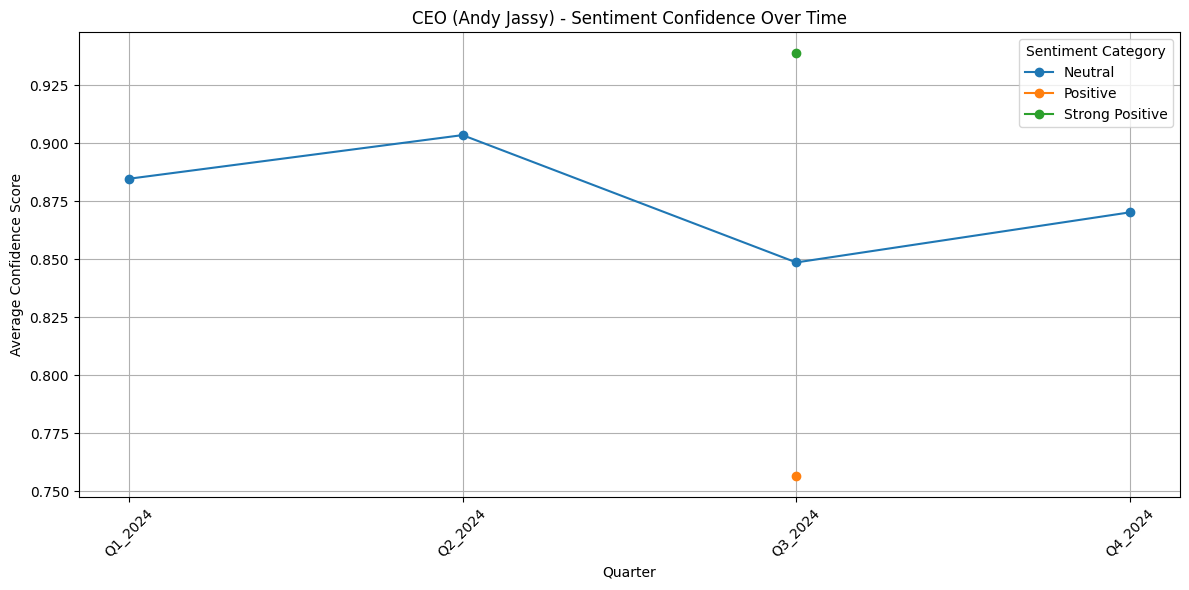

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (if not already loaded)
# df = pd.read_csv("AMAZON_finbert_output.csv")

# Normalize speaker name to a single consistent label
# replace variant of "Jassy" with "Andrew R. Jassy"
df['speaker_normalized'] = df['speaker'].str.replace(r'(?i).*jassy.*', 'Andrew R. Jassy', regex=True)

# STEP 2: Now filter on the normalized name
ceo_data = df[df['speaker_normalized'] == 'Andrew R. Jassy'].copy()

# Group and compute average confidence by quarter and sentiment category
ceo_summary = ceo_data.groupby(['quarter', 'sentiment_category']).agg(
    avg_confidence=('confidence', 'mean'),
    count=('confidence', 'count')
).reset_index()

# Pivot the data for plotting
ceo_pivot = ceo_summary.pivot(index='quarter', columns='sentiment_category', values='avg_confidence')

# Plot the sentiment trend
plt.figure(figsize=(12, 6))
for sentiment in ceo_pivot.columns:
    plt.plot(ceo_pivot.index, ceo_pivot[sentiment], marker='o', label=sentiment)

plt.title("CEO (Andy Jassy) - Sentiment Confidence Over Time")
plt.xlabel("Quarter")
plt.ylabel("Average Confidence Score")
plt.xticks(rotation=45)
plt.legend(title="Sentiment Category")
plt.grid(True)
plt.tight_layout()
plt.show()


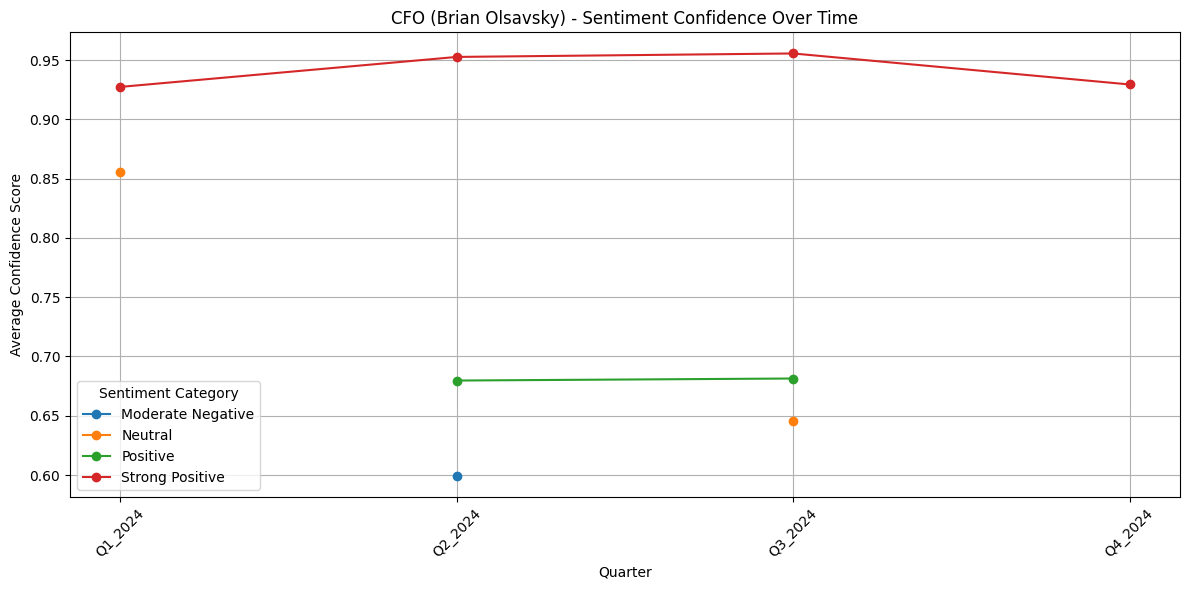

In [11]:
# Normalising variation of Olsavsky to "Brian Olsavsky"
df['speaker_normalized'] = df['speaker'].str.replace(r'(?i).*olsavsky.*', 'Brian Olsavsky', regex=True)

# Now filter using the normalized column
cfo_data = df[df['speaker_normalized'] == 'Brian Olsavsky'].copy()
# Group by quarter and sentiment category to get average confidence
cfo_summary = cfo_data.groupby(['quarter', 'sentiment_category']).agg(
    avg_confidence=('confidence', 'mean'),
    count=('confidence', 'count')
).reset_index()

# Pivot the data for easier plotting
cfo_pivot = cfo_summary.pivot(index='quarter', columns='sentiment_category', values='avg_confidence')

# Plot CFO sentiment confidence over time
plt.figure(figsize=(12, 6))
for sentiment in cfo_pivot.columns:
    plt.plot(cfo_pivot.index, cfo_pivot[sentiment], marker='o', label=sentiment)

plt.title("CFO (Brian Olsavsky) - Sentiment Confidence Over Time")
plt.xlabel("Quarter")
plt.ylabel("Average Confidence Score")
plt.xticks(rotation=45)
plt.legend(title="Sentiment Category")
plt.grid(True)
plt.tight_layout()
plt.show()

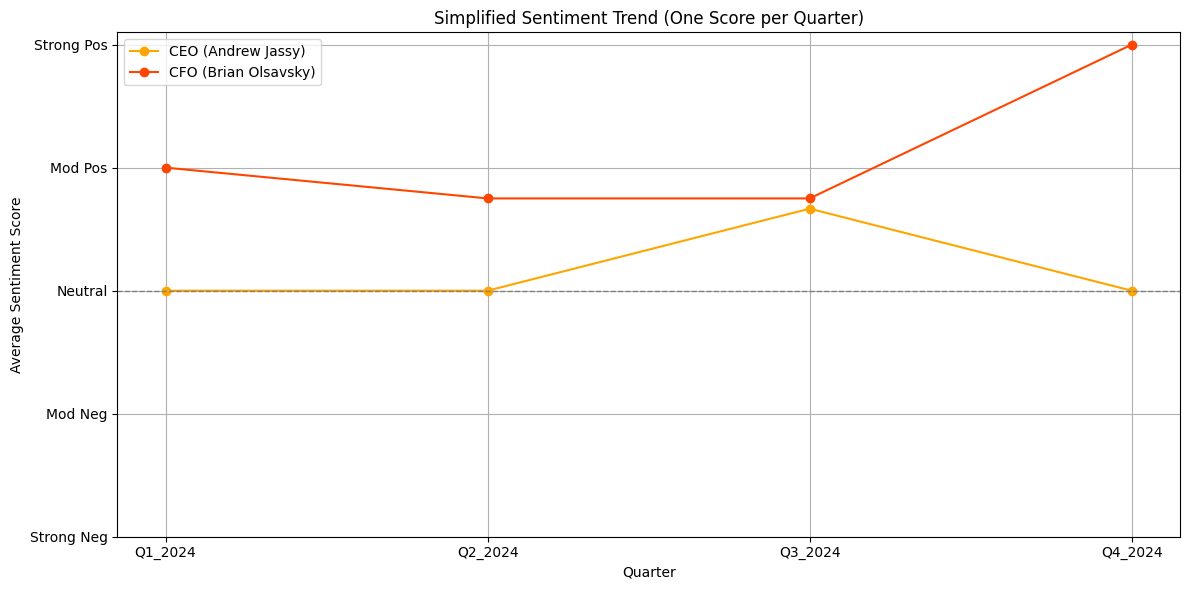

In [ ]:
# Map sentiment category to a numeric scale
sentiment_order = {
    'Strong Negative': -2,
    'Slightly Negative': -1,
    'Neutral': 0,
    'SlightlyPositive': 1,
    'Strong Positive': 2
}
ceo_data['sentiment_score'] = ceo_data['sentiment_category'].map(sentiment_order)
cfo_data['sentiment_score'] = cfo_data['sentiment_category'].map(sentiment_order)

# Average sentiment score per quarter
ceo_trend = ceo_data.groupby('quarter')['sentiment_score'].mean().reset_index()
ceo_trend['role'] = 'CEO'

cfo_trend = cfo_data.groupby('quarter')['sentiment_score'].mean().reset_index()
cfo_trend['role'] = 'CFO'

# Combine data
combined = pd.concat([ceo_trend, cfo_trend])
pivot_df = combined.pivot(index='quarter', columns='role', values='sentiment_score')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(pivot_df.index, pivot_df['CEO'], marker='o', label='CEO (Andrew Jassy)', color='orange')
plt.plot(pivot_df.index, pivot_df['CFO'], marker='o', label='CFO (Brian Olsavsky)', color='orangered')

plt.title("Simplified Sentiment Trend (One Score per Quarter)")
plt.xlabel("Quarter")
plt.ylabel("Average Sentiment Score")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.yticks([-2, -1, 0, 1, 2], ['Strong Neg', 'Mod Neg', 'Neutral', 'Mod Pos', 'Strong Pos'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [13]:
# CEO sentiment table
ceo_table = ceo_data.groupby('quarter').agg({
    'sentiment_category': lambda x: ', '.join(x.unique()),
    'confidence': 'mean'
}).reset_index()

print("CEO Sentiment Table:")
print(ceo_table)
print("\n")

# CFO sentiment table
cfo_table = cfo_data.groupby('quarter').agg({
    'sentiment_category': lambda x: ', '.join(x.unique()),
    'confidence': 'mean'
}).reset_index()

print("CFO Sentiment Table:")
print(cfo_table)
print("\n")

# CEO vs CFO comparison table
comparison_table = ceo_table.merge(cfo_table, on='quarter', suffixes=('_ceo', '_cfo'))

print("CEO vs CFO Sentiment Comparison Table:")
print(comparison_table)


CEO Sentiment Table:
   quarter                  sentiment_category  confidence
0  Q1_2024                             Neutral    0.884644
1  Q2_2024                             Neutral    0.903458
2  Q3_2024  Strong Positive, Neutral, Positive    0.832917
3  Q4_2024                             Neutral    0.870184


CFO Sentiment Table:
   quarter                            sentiment_category  confidence
0  Q1_2024                      Strong Positive, Neutral    0.891428
1  Q2_2024  Strong Positive, Positive, Moderate Negative    0.727832
2  Q3_2024            Strong Positive, Neutral, Positive    0.731867
3  Q4_2024                               Strong Positive    0.929532


CEO vs CFO Sentiment Comparison Table:
   quarter              sentiment_category_ceo  confidence_ceo  \
0  Q1_2024                             Neutral        0.884644   
1  Q2_2024                             Neutral        0.903458   
2  Q3_2024  Strong Positive, Neutral, Positive        0.832917   
3  Q4_2024 

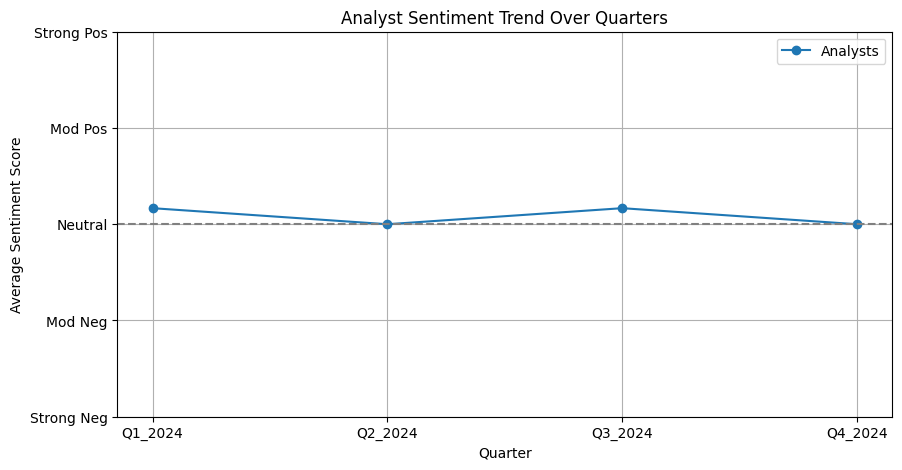

Analyst Sentiment Table:
   quarter sentiment_category  confidence
0  Q1_2024  Neutral, Positive    0.742984
1  Q2_2024            Neutral    0.741231
2  Q3_2024  Neutral, Positive    0.797992
3  Q4_2024            Neutral    0.792584


In [ ]:
## Now, we filter the analyst data
# Filter analyst data
analyst_data = df[df['title'].str.contains("Analyst", case=False, na=False)].copy()

# Map sentiment category to numeric score (if needed)
sentiment_order = {
    'Strong Negative': -2,
    'Slightly Negative': -1,
    'Neutral': 0,
    'Slightly Positive': 1,
    'Strong Positive': 2
}
analyst_data['sentiment_score'] = analyst_data['sentiment_category'].map(sentiment_order)

# Calculate average sentiment score per quarter
analyst_trend = analyst_data.groupby('quarter')['sentiment_score'].mean().reset_index()

# Plot temporal trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(analyst_trend['quarter'], analyst_trend['sentiment_score'], marker='o', label='Analysts')
plt.title("Analyst Sentiment Trend Over Quarters")
plt.xlabel("Quarter")
plt.ylabel("Average Sentiment Score")
plt.axhline(0, color='gray', linestyle='--')
plt.yticks([-2, -1, 0, 1, 2], ['Strong Neg', 'Mod Neg', 'Neutral', 'Mod Pos', 'Strong Pos'])
plt.grid(True)
plt.legend()
plt.show()

# Create and print table
analyst_table = analyst_data.groupby('quarter').agg({
    'sentiment_category': lambda x: ', '.join(x.unique()),
    'confidence': 'mean'
}).reset_index()

print("Analyst Sentiment Table:")
print(analyst_table)


Comparison Table (Average Sentiment Score):
role  quarter   Analyst       CEO   CFO
0     Q1_2024  0.166667  0.000000  1.00
1     Q2_2024  0.000000  0.000000  0.75
2     Q3_2024  0.166667  0.666667  0.75
3     Q4_2024  0.000000  0.000000  2.00


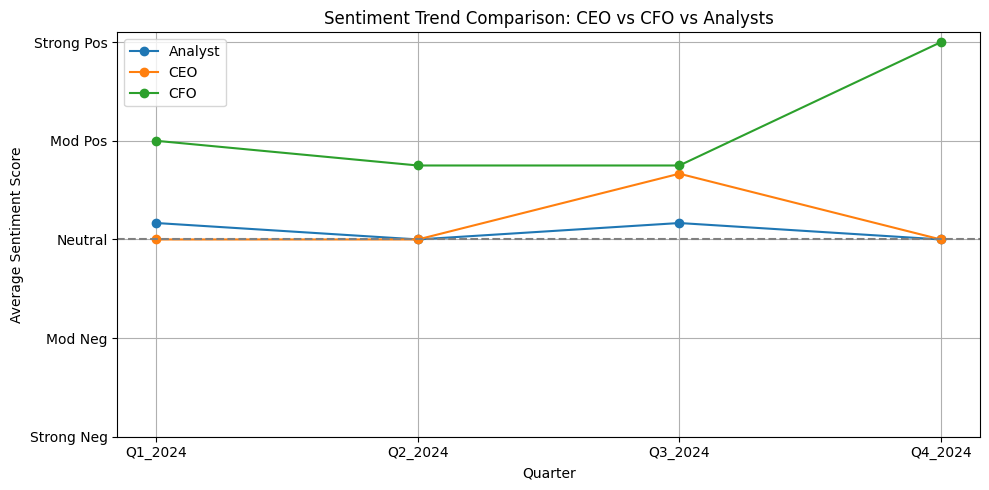

In [ ]:
import matplotlib.pyplot as plt

# Combine sentiment trend data for CEO, CFO, and Analysts
combined_roles = pd.concat([
    ceo_data.assign(role='CEO'),
    cfo_data.assign(role='CFO'),
    analyst_data.assign(role='Analyst')
])

# Map sentiment category to numeric score
sentiment_order = {
    'Strong Negative': -2,
    'Slightly Negative': -1,
    'Neutral': 0,
    'Slightly Positive': 1,
    'Strong Positive': 2
}
combined_roles['sentiment_score'] = combined_roles['sentiment_category'].map(sentiment_order)

# Calculate average sentiment score per quarter per role
trend_data = combined_roles.groupby(['quarter', 'role'])['sentiment_score'].mean().reset_index()

# Pivot for table
comparison_table = trend_data.pivot(index='quarter', columns='role', values='sentiment_score').reset_index()

# Print comparison table
print("Comparison Table (Average Sentiment Score):")
print(comparison_table)

# Plot
plt.figure(figsize=(10, 5))
for role in trend_data['role'].unique():
    role_data = trend_data[trend_data['role'] == role]
    plt.plot(role_data['quarter'], role_data['sentiment_score'], marker='o', label=role)

plt.title("Sentiment Trend Comparison: CEO vs CFO vs Analysts")
plt.xlabel("Quarter")
plt.ylabel("Average Sentiment Score")
plt.axhline(0, color='gray', linestyle='--')
plt.yticks([-2, -1, 0, 1, 2], ['Strong Neg', 'Mod Neg', 'Neutral', 'Mod Pos', 'Strong Pos'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


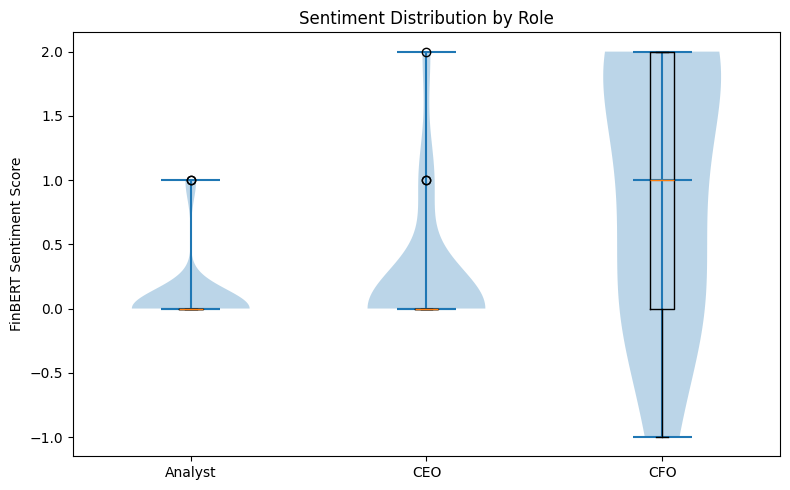

In [ ]:
## Sentiment dirstribution by Role
# 1) Sentiment Distribution by Role (Violin + Boxplot)
roles = ['Analyst', 'CEO', 'CFO']

# Map sentiment categories to numeric scores
sentiment_order = {
	'Strong Negative': -2,
	'Slightly Negative': -1,
	'Neutral': 0,
	'Slightly Positive': 1,
	'Strong Positive': 2
}

# If not already present, create a numeric column
if 'sentiment_score' not in df.columns:
	df['sentiment_score'] = df['sentiment_category'].map(sentiment_order)

# Prepare role-based sentiment data
data = []
for r in roles:
    if r == 'CEO':
        mask = df['speaker_normalized'] == "Andrew R. Jassy"
    elif r == 'CFO':
        mask = df['speaker_normalized'] == "Brian Olsavsky"
    else:
        mask = df['title'].str.contains("Analyst", case=False, na=False)
    
    data.append(df.loc[mask, 'sentiment_score'].dropna())

fig, ax = plt.subplots(figsize=(8, 5))
# Violin plot
ax.violinplot(data, positions=[1, 2, 3], showmeans=False, showmedians=True)
# Boxplot overlay
ax.boxplot(data, widths=0.1, positions=[1, 2, 3], showfliers=True)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(roles)
ax.set_ylabel('FinBERT Sentiment Score')
ax.set_title('Sentiment Distribution by Role')
plt.tight_layout()
plt.show()

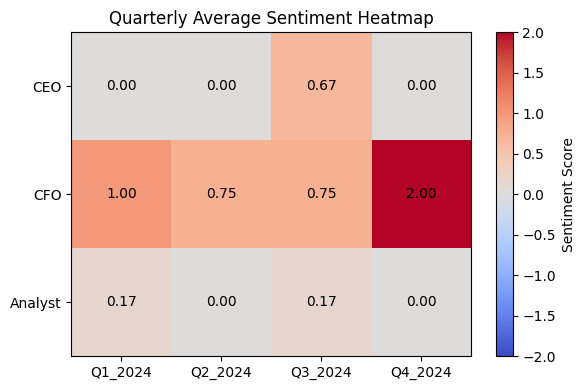

In [17]:
#Quarterly Average Sentiment Heatmap
import numpy as np
import matplotlib.pyplot as plt

# Ensure sentiment score exists
sentiment_order = {
    'Strong Negative': -2,
    'Moderate Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Strong Positive': 2
}
if 'sentiment_score' not in df.columns:
    df['sentiment_score'] = df['sentiment_category'].map(sentiment_order)

# Normalize speaker names (if not already done)
df['speaker_normalized'] = df['speaker'].str.replace(r'(?i).*jassy.*', 'Andrew R. Jassy', regex=True)
df['speaker_normalized'] = df['speaker_normalized'].str.replace(r'(?i).*olsavsky.*', 'Brian Olsavsky', regex=True)

# Assign roles based on normalized names
def get_role(row):
    if row.get('speaker_normalized') == 'Andrew R. Jassy':
        return 'CEO'
    elif row.get('speaker_normalized') == 'Brian Olsavsky':
        return 'CFO'
    elif isinstance(row.get('title'), str) and 'Analyst' in row['title']:
        return 'Analyst'
    else:
        return None

df['role'] = df.apply(get_role, axis=1)

# Filter only rows with defined roles
df_roles = df[df['role'].isin(['CEO', 'CFO', 'Analyst'])].copy()

# Pivot table of average sentiment by role and quarter
pivot = df_roles.pivot_table(
    index='role',
    columns='quarter',
    values='sentiment_score',
    aggfunc='mean'
).reindex(['CEO', 'CFO', 'Analyst'])

# Plot heatmap
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(pivot.values, aspect='auto', cmap='coolwarm', vmin=-2, vmax=2)

# Label axes
ax.set_xticks(np.arange(pivot.shape[1]))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(np.arange(pivot.shape[0]))
ax.set_yticklabels(pivot.index)
ax.set_title('Quarterly Average Sentiment Heatmap')

# Annotate each cell with value
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        value = pivot.iloc[i, j]
        if not np.isnan(value):
            ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='black')

plt.colorbar(im, ax=ax, label='Sentiment Score')
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

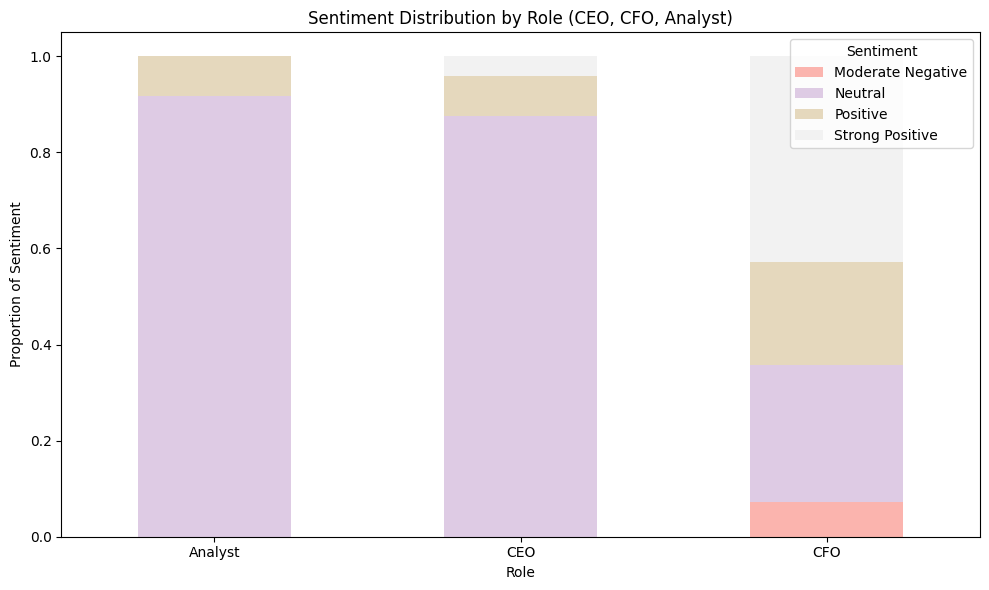

In [18]:
import matplotlib.pyplot as plt

# Load the FinBERT output
df = pd.read_csv("clean_transcripts/AMAZON_finbert_output.csv")

# Map roles from job titles
def map_role(title):
    title = str(title).lower()
    if 'chief executive officer' in title or 'ceo' in title:
        return 'CEO'
    elif 'chief financial officer' in title or 'cfo' in title:
        return 'CFO'
    elif 'analyst' in title:
        return 'Analyst'
    else:
        return 'Other'

# Apply role mapping
df['role_category'] = df['title'].apply(map_role)

# Filter only CEO, CFO, Analyst roles
filtered_df = df[df['role_category'].isin(['CEO', 'CFO', 'Analyst'])]

# Group by role and sentiment category
role_sentiment_counts = filtered_df.groupby(['role_category', 'sentiment_category']).size().unstack(fill_value=0)

# Normalize to percentage
role_sentiment_percent = role_sentiment_counts.div(role_sentiment_counts.sum(axis=1), axis=0)

# Plot
plt.figure(figsize=(10, 6))
role_sentiment_percent.plot(kind='bar', stacked=True, colormap='Pastel1', figsize=(10, 6))

plt.title('Sentiment Distribution by Role (CEO, CFO, Analyst)')
plt.ylabel('Proportion of Sentiment')
plt.xlabel('Role')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


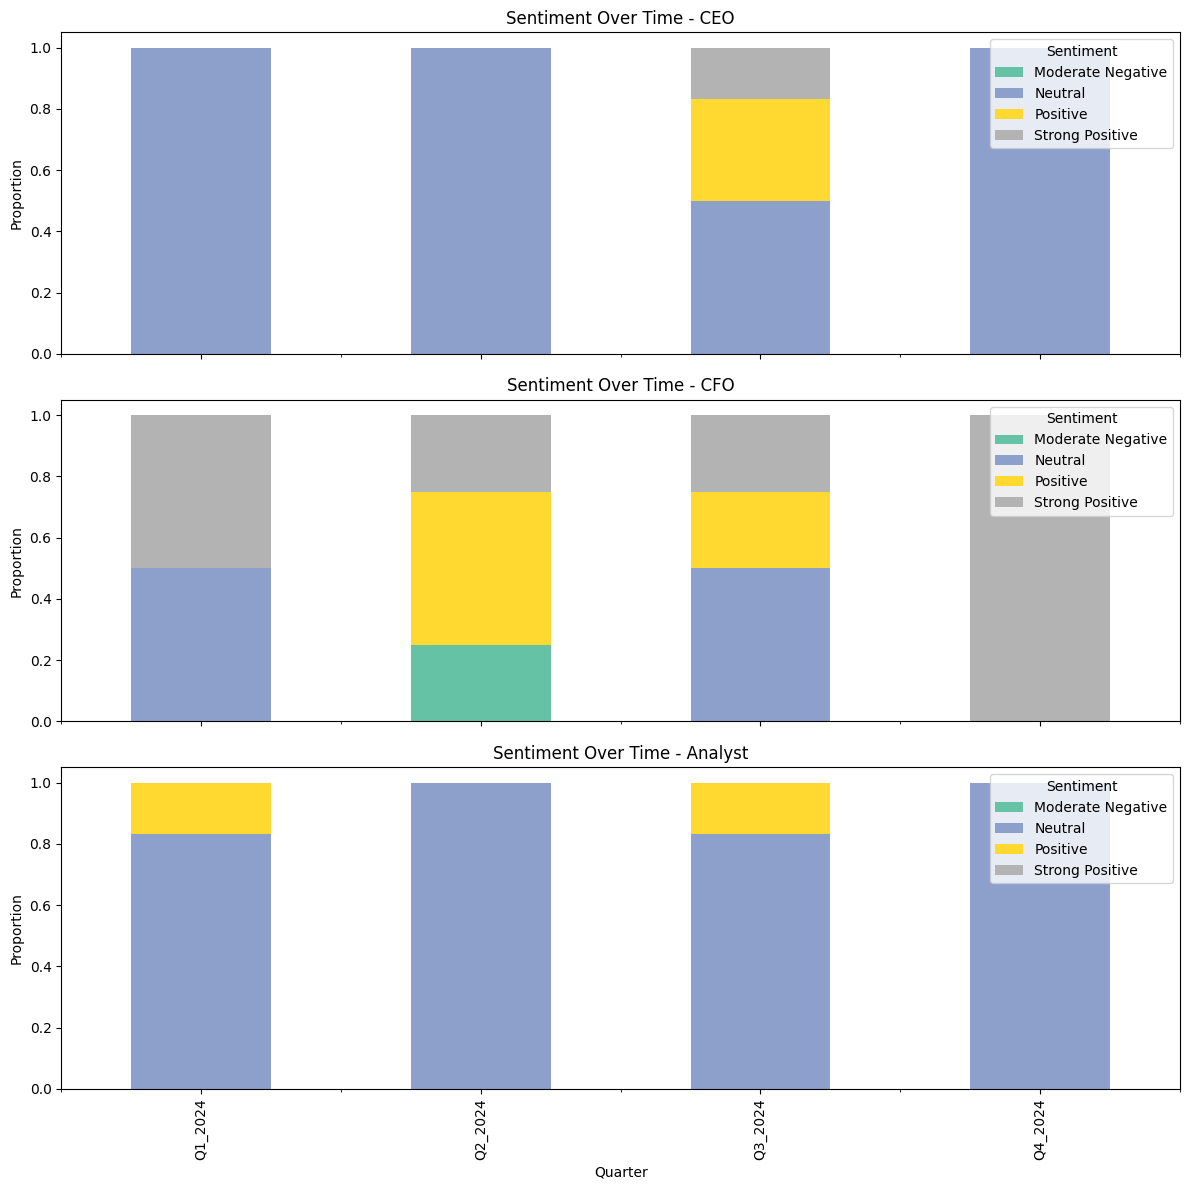

In [19]:
# Step 3: Group by quarter, role, sentiment category
temporal_counts = filtered_df.groupby(['quarter', 'role_category', 'sentiment_category']) \
                             .size().reset_index(name='count')

# Step 4: Normalize to get sentiment proportions
temporal_counts['total'] = temporal_counts.groupby(['quarter', 'role_category'])['count'].transform('sum')
temporal_counts['proportion'] = temporal_counts['count'] / temporal_counts['total']

# Step 5: Pivot table to create sentiment matrix
sentiment_table = temporal_counts.pivot_table(index=['quarter', 'role_category'],
                                              columns='sentiment_category',
                                              values='proportion',
                                              fill_value=0).reset_index()

# Optional: Save sentiment table to CSV
sentiment_table.to_csv("apple_role_sentiment_table.csv", index=False)

# Step 6: Plotting sentiment distribution over time by role
roles = ['CEO', 'CFO', 'Analyst']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=True)

for i, role in enumerate(roles):
    role_data = sentiment_table[sentiment_table['role_category'] == role].set_index('quarter')
    role_data.drop(columns='role_category', inplace=True)
    
    role_data.plot(kind='bar', stacked=True, ax=axes[i], colormap='Set2')
    axes[i].set_title(f'Sentiment Over Time - {role}')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Sentiment', loc='upper right')

plt.xlabel('Quarter')
plt.tight_layout()
plt.show()


In [20]:
# Step 2: Function to generate summary table for any role
def get_sentiment_table_by_role(df, role_name):
    role_df = df[df['role_category'] == role_name]
    
    summary = role_df.groupby('quarter').agg({
        'sentiment_category': lambda x: ', '.join(sorted(set(x))),
        'confidence': 'mean'
    }).reset_index()
    
    summary['confidence'] = summary['confidence'].round(6)
    summary.insert(0, 'role', role_name)
    return summary

# Step 3: Generate tables for CEO, CFO, and Analyst
ceo_table = get_sentiment_table_by_role(df, 'CEO')
cfo_table = get_sentiment_table_by_role(df, 'CFO')
analyst_table = get_sentiment_table_by_role(df, 'Analyst')

# Optional: Save to CSV or display
# ceo_table.to_csv("ceo_sentiment_summary.csv", index=False)
# cfo_table.to_csv("cfo_sentiment_summary.csv", index=False)
# analyst_table.to_csv("analyst_sentiment_summary.csv", index=False)

# Display
print("CEO Sentiment Table:")
print(ceo_table.drop(columns='role'), '\n')

print("CFO Sentiment Table:")
print(cfo_table.drop(columns='role'), '\n')

print("Analyst Sentiment Table:")
print(analyst_table.drop(columns='role'))

CEO Sentiment Table:
   quarter                  sentiment_category  confidence
0  Q1_2024                             Neutral    0.884644
1  Q2_2024                             Neutral    0.903458
2  Q3_2024  Neutral, Positive, Strong Positive    0.832917
3  Q4_2024                             Neutral    0.870184 

CFO Sentiment Table:
   quarter                            sentiment_category  confidence
0  Q1_2024                      Neutral, Strong Positive    0.891428
1  Q2_2024  Moderate Negative, Positive, Strong Positive    0.727832
2  Q3_2024            Neutral, Positive, Strong Positive    0.731867
3  Q4_2024                               Strong Positive    0.929532 

Analyst Sentiment Table:
   quarter sentiment_category  confidence
0  Q1_2024  Neutral, Positive    0.742984
1  Q2_2024            Neutral    0.741231
2  Q3_2024  Neutral, Positive    0.797992
3  Q4_2024            Neutral    0.792584


# Step 7: using LLMs to get sentiment score for each block

## API call

In [23]:
api_key = 'sk-58c0df73519c42debe27d41e164d455a'
base_url = "https://api.deepseek.com"
client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")
seed = 42

## Getting the sentiment score for each blocks of text using an LLM.

In [ ]:
# Build a payload of {id, text} objects
payload = (
    df[["content"]]
    .reset_index()                             # bring the DataFrame index into a column
    .rename(columns={"index": "id", "content": "text"})
    .to_dict(orient="records")
)

# Craft your messages
system_prompt = """
You are a sentiment-analysis engine.
I will give you a JSON array of objects like:
  [ { "id": 0, "text": "…"}, { "id": 1, "text": "…"}, … ]

For each text, return a probability distribution over the five sentiment classes:
Strongly Negative, Slightly Negative, Neutral, Slightly Positive, Strongly Positive.
Label your columns:

id,
LLM_sentiment, 
LLM_pct_strong_positive,
LLM_pct_slightly_positive,
LLM_pct_neutral,
LLM_pct_slightly_negative,
LLM_pct_strongly_negative

—with each LLM_pct_* a float from 0.0–1.0 summing to 1.0, one row per paragraph,
no markdown fences or commentary, pure CSV.
-for sentiment, choose one of the five classes. 
"""

resp = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user",   "content": json.dumps(payload, indent=2)}
    ],
    temperature=0.0,
    top_p=1.0
)


## Merging with the original df

In [38]:
msg = resp.choices[0].message
csv_str = msg.content
# Convert CSV string to DataFrame
sent_df = pd.read_csv(io.StringIO(csv_str))
df = df.reset_index(drop=False).rename(columns={'index':'id'})
df_with_sentiment = df.merge(
    sent_df,            # contains id, sentiment, pct_*
    on='id',            # join key
    how='left'          # keep every original row
)

df_with_sentiment.drop(columns=['id'], inplace=True)  # drop the id column

df_with_sentiment

,quarter,speaker,title,content,sentiment,confidence,sentiment_category,role_category,LLM_sentiment,LLM_pct_strong_positive,LLM_pct_positive,LLM_pct_neutral,LLM_pct_negative,LLM_pct_strongly_negative
0,Q1_2024,Dave Fildes,"Director, Investor Relations",They just revealed what they believe are the 1...,neutral,0.943745,Neutral,Other,Neutral,0.1,0.2,0.5,0.1,0.1
1,Q1_2024,Andy Jassy,Chief Executive Officer,"Thanks, Dave. Today, we're reporting $143.3 bi...",neutral,0.909178,Neutral,CEO,Positive,0.2,0.4,0.3,0.1,0.0
2,Q1_2024,Brian Olsavsky,Chief Financial Officer,"Thanks, Andy. Starting with our top line finan...",positive,0.953807,Strong Positive,CFO,Positive,0.2,0.4,0.3,0.1,0.0
3,Q1_2024,Doug Anmuth,JPMorgan Chase and Company -- Analyst,Thanks so much for taking the question. Probab...,neutral,0.871681,Neutral,Analyst,Neutral,0.1,0.2,0.5,0.1,0.1
4,Q1_2024,Brian Olsavsky,Chief Financial Officer,"Hi. Doug, yeah, we have historically always me...",positive,0.901179,Strong Positive,CFO,Neutral,0.1,0.2,0.5,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Q4_2024,John Blackledge,Analyst,Great. Thanks. Could you talk about the curren...,neutral,0.633271,Neutral,Analyst,Neutral,0.1,0.2,0.5,0.1,0.1
69,Q4_2024,Andrew R. Jassy,President and Chief Executive Officer,Yeah. I would say on speed of delivery that we...,neutral,0.912455,Neutral,CEO,Positive,0.2,0.4,0.3,0.1,0.0
70,Q4_2024,Michael Morton,Analyst,Hi. Thank you so much for the question. I want...,neutral,0.913333,Neutral,Analyst,Neutral,0.1,0.2,0.5,0.1,0.1
71,Q4_2024,Andrew R. Jassy,President and Chief Executive Officer,"Well, I would say that I think retailers ourse...",neutral,0.911709,Neutral,CEO,Positive,0.2,0.4,0.3,0.1,0.0


In [ ]:
#save df_with_sentiment to csv
output_path = 'clean_transcripts/AMAZON_finbert_deepseek_output.csv'
df_with_sentiment.to_csv(output_path, index=False)
print(f"Saved sentiment output to {output_path}")

In [4]:
AMAZON_final = pd.read_csv("AMAZON_full.csv")

# Select only the required columns
AMAZON_final = AMAZON_final[[
    "quarter",
    "content",
    "sentiment_category",
    "title",
    "LLM_sentiment",
    "Manual Annotation"
]]

# Rename columns
AMAZON_final = AMAZON_final.rename(columns={
    "sentiment_category": "FinBERT_sentiment",
    "Manual Annotation": "manual_annotation"
})

# Rearrange columns so role_category comes before FinBERT_sentiment
AMAZON_final = AMAZON_final[[
    "quarter",
    "content",
    "title",
    "FinBERT_sentiment",
    "LLM_sentiment",
    "manual_annotation"
]]

# Check the updated dataframe
print(AMAZON_final)

     quarter                                            content  \
0    Q1_2024  They just revealed what they believe are the 1...   
1    Q1_2024  Thanks, Dave. Today, we're reporting $143.3 bi...   
2    Q1_2024  Thanks, Andy. Starting with our top line finan...   
3    Q1_2024  Thanks so much for taking the question. Probab...   
4    Q1_2024  Hi. Doug, yeah, we have historically always me...   
..       ...                                                ...   
138  Q4_2023  Thanks, everyone. I have one on grocery and on...   
139  Q4_2023  Yeah. On grocery, we're pleased with the progr...   
140  Q4_2023  Thanks very much. I just wanted to follow up o...   
141  Q4_2023  Yeah. So, Colin, I would say a few things on -...   
142  Q4_2023  Thanks for joining us today on the call and fo...   

                                      title FinBERT_sentiment  \
0              Director, Investor Relations           Neutral   
1                   Chief Executive Officer           Neutral   
